In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import spearmanr

from tqdm import trange

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# import torch #https://github.com/facebookresearch/esm
# torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 3 on the node
# print(torch.cuda.get_device_name(0))

### Loading interaction df

In [2]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

# Adding new target id
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}

for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1

interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


### Loading p @ Ls (cutoff = 8A, minimal sequence separation = 6)

In [3]:
patLs_df = pd.read_csv("/work3/s232958/data/meta_analysis/binder_p_at_Ls_thres8_6.csv")
patLs_df

,binder_id,contact_map,head1,head2,head3,head4,head5,head6,head7,head8,...,head11,head12,head13,head14,head15,head16,head17,head18,head19,head20
0,VirB8_1,0.700,0.075,0.125,0.125,0.125,0.075,0.025,0.300,0.075,...,0.300,0.300,0.375,0.575,0.175,0.200,0.125,0.150,0.300,0.125
1,FGFR2_1,0.371,0.016,0.065,0.016,0.129,0.032,0.048,0.145,0.065,...,0.113,0.065,0.145,0.355,0.097,0.016,0.048,0.032,0.226,0.097
2,FGFR2_2,0.623,0.033,0.115,0.049,0.131,0.115,0.016,0.213,0.115,...,0.180,0.148,0.361,0.443,0.115,0.049,0.098,0.049,0.492,0.131
3,FGFR2_3,0.594,0.016,0.062,0.078,0.109,0.141,0.016,0.188,0.125,...,0.141,0.094,0.188,0.578,0.141,0.016,0.141,0.016,0.453,0.125
4,FGFR2_4,0.297,0.031,0.078,0.062,0.109,0.078,0.000,0.062,0.062,...,0.031,0.031,0.156,0.188,0.094,0.000,0.016,0.016,0.219,0.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,IL2Ra_62,0.473,0.018,0.000,0.036,0.036,0.073,0.018,0.055,0.055,...,0.073,0.091,0.109,0.418,0.000,0.018,0.036,0.000,0.327,0.145
3528,IL2Ra_63,0.429,0.000,0.018,0.089,0.018,0.071,0.000,0.071,0.161,...,0.054,0.054,0.161,0.321,0.071,0.000,0.000,0.000,0.304,0.036
3529,IL2Ra_64,0.536,0.054,0.071,0.054,0.125,0.125,0.018,0.161,0.196,...,0.196,0.089,0.232,0.339,0.107,0.036,0.161,0.107,0.464,0.018
3530,IL2Ra_65,0.351,0.000,0.105,0.053,0.175,0.105,0.018,0.053,0.053,...,0.140,0.123,0.140,0.333,0.000,0.018,0.070,0.018,0.316,0.140


### Loading average log-likelihood / pseudo-perplexity

In [4]:
averageLL_pPLL_df = pd.read_csv("/work3/s232958/data/meta_analysis/averageLL_pPLL.csv").drop(columns= ["binder_id"]).rename(columns = {"target_binder_ID" : "binder_id"})
averageLL_pPLL_df

,binder_id,seq_binder,avg_log_likelihood,pseudo_perplexity
0,VirB8_1,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,-2.749460,15.634179
1,FGFR2_1,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,-2.732485,15.371030
2,FGFR2_2,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,-2.527573,12.523080
3,FGFR2_3,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,-2.289752,9.872489
4,FGFR2_4,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,-2.577624,13.165817
...,...,...,...,...
3527,IL2Ra_62,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,-2.042634,7.710890
3528,IL2Ra_63,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,-1.827751,6.219881
3529,IL2Ra_64,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,-1.441779,4.228210
3530,IL2Ra_65,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,-2.069157,7.918145


In [5]:
final_df = pd.merge(
    averageLL_pPLL_df[["binder_id", "seq_binder", "avg_log_likelihood", "pseudo_perplexity"]],
    patLs_df,
    on="binder_id",
    how="inner"
)
final_df = final_df.rename(columns = {
    "contact_map" : "contact_head"
})

### Plotting:
- contact heads p@L vs attention p@L
- p@L vs PLL

### contact heads p@L vs attention p@L

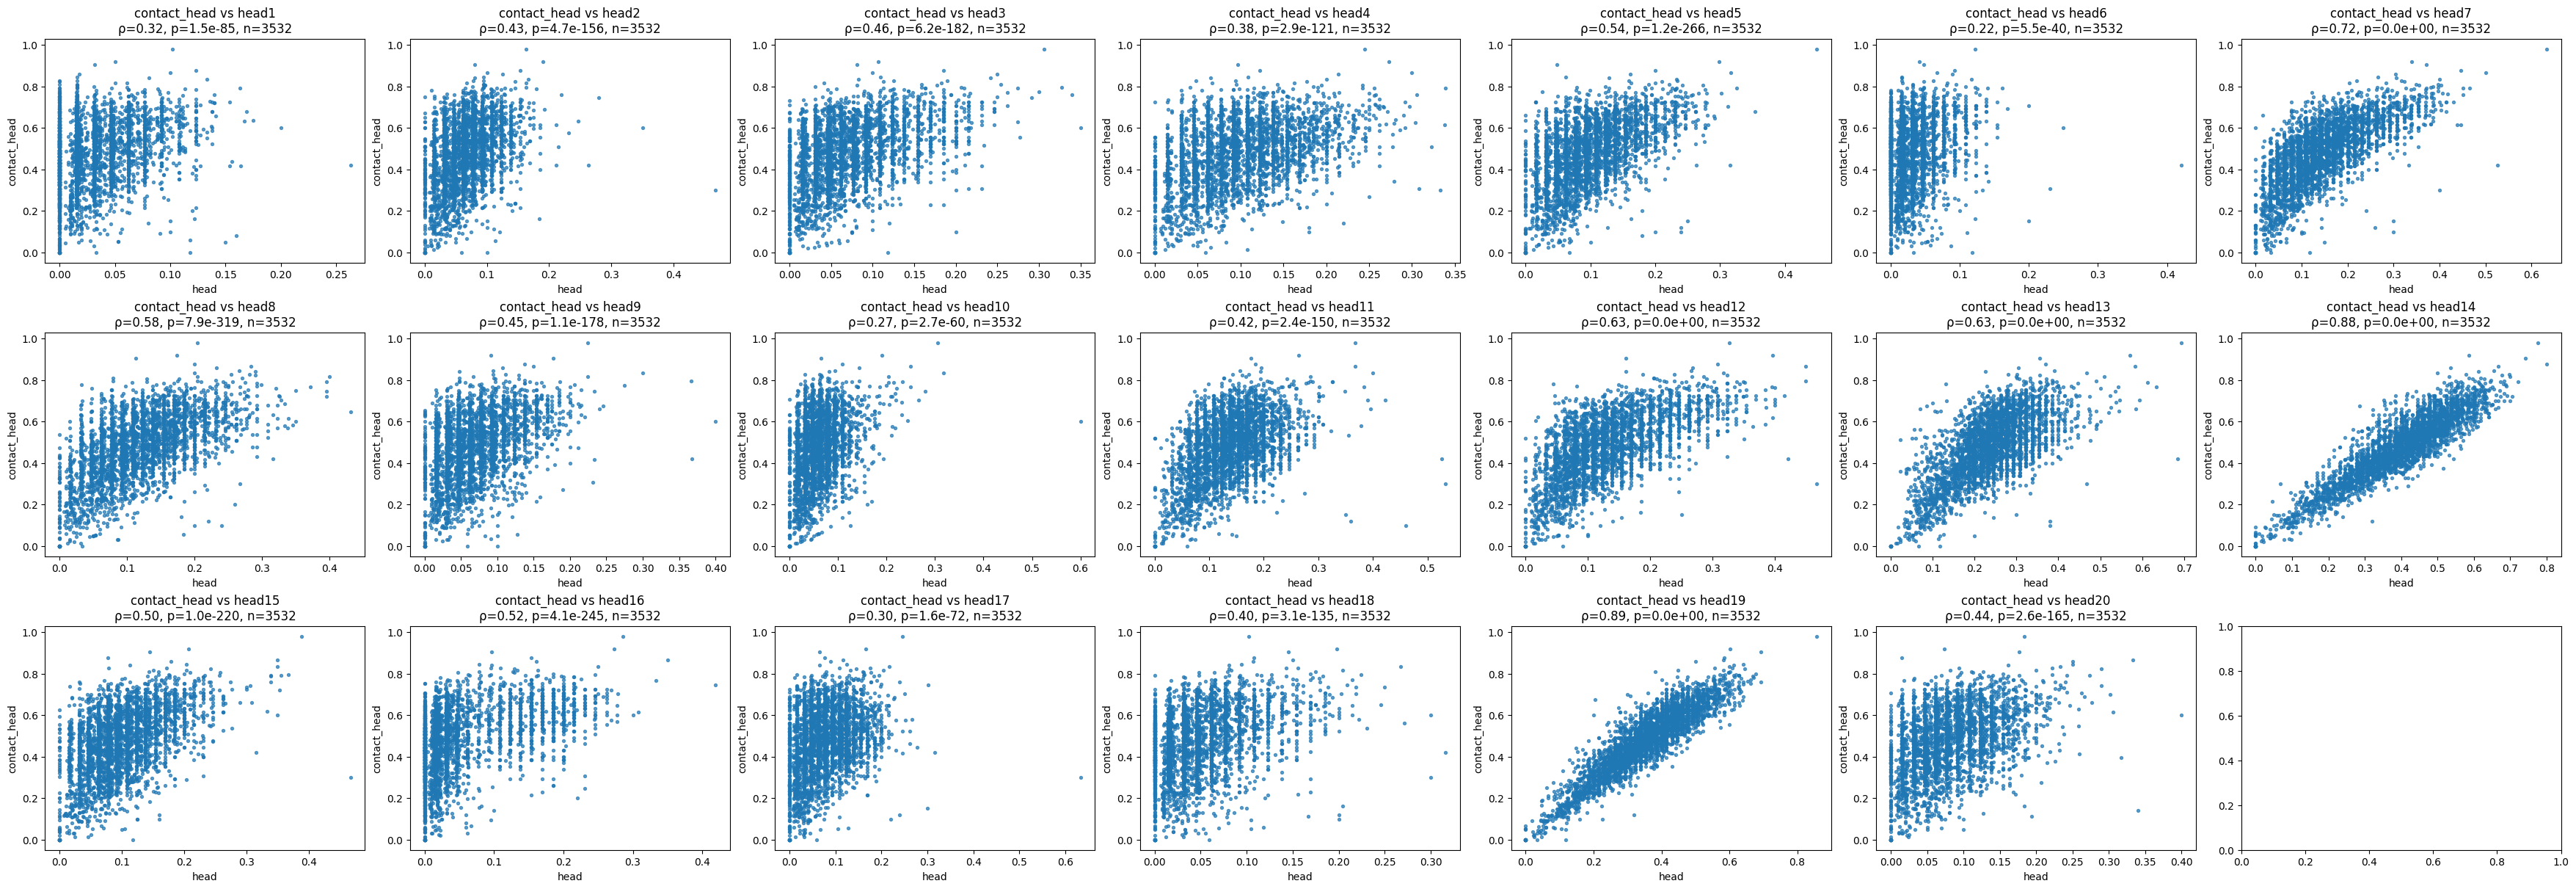

In [6]:
heads_list = [f"head{i}" for i in range(1, 21)]
nplots = len(heads_list)
ncols = 7
nrows = ceil(nplots / ncols) # 5

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = np.array(axes).reshape(nrows, ncols)

for ax, head in zip(axes.ravel(), heads_list):
    x, y = final_df[head].to_numpy(), final_df["contact_head"].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)

    # plotting
    ax.scatter(x, y, s=8, alpha=0.7)
    ax.set_title(f"contact_head vs {head}\nρ={rho:.2f}, p={p:.1e}, n={len(x)}")
    ax.set_xlabel(f"head")
    ax.set_ylabel("contact_head")

plt.show()

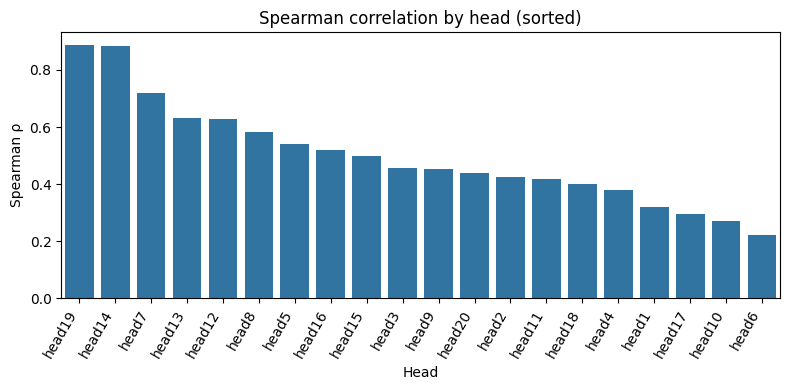

In [7]:
spear_list = []
for ax, head in zip(axes.ravel(), heads_list):
    x, y = final_df[head].to_numpy(), final_df["contact_head"].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)
    spear_list.append((f"{head}", rho))
    # print(f"{head}\n ρ={rho:.2f}, p={p:.1e}, n={len(x)}")
sorted_list = sorted(spear_list, key=lambda t: t[1], reverse = True)
ys = [y[1] for y in sorted_list]
xs = [x[0] for x in sorted_list]

plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)  # use ci=None if older seaborn
ax.set_ylabel("Spearman ρ")
ax.set_xlabel("Head")
ax.set_title("Spearman correlation by head (sorted)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

### P@L vs PPL

In [8]:
xcol = "pseudo_perplexity"
ycols = ["contact_head"] + [f"head{i}" for i in range(1, 21)]

# cover NaNs
work = final_df[[xcol] + ycols].replace([np.inf, -np.inf], np.nan)

rows = []
for y in ycols:
    s = work[[xcol, y]].dropna()
    rho, p = spearmanr(s[xcol], s[y])
    rows.append({"metric": y, "n": len(s), "spearman_rho": rho})

corr_df = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
print(corr_df.to_string(index=False))

      metric    n  spearman_rho
      head16 3532      0.270926
      head18 3532      0.169459
       head9 3532      0.157323
      head20 3532      0.118612
      head15 3532      0.114872
      head12 3532      0.083118
       head3 3532      0.035205
       head2 3532      0.033208
contact_head 3532      0.021107
      head13 3532      0.017357
       head7 3532     -0.009362
       head6 3532     -0.013330
      head14 3532     -0.034291
      head10 3532     -0.050699
      head19 3532     -0.056100
      head17 3532     -0.086520
       head5 3532     -0.087900
       head1 3532     -0.099722
       head4 3532     -0.104513
       head8 3532     -0.114241
      head11 3532     -0.217367


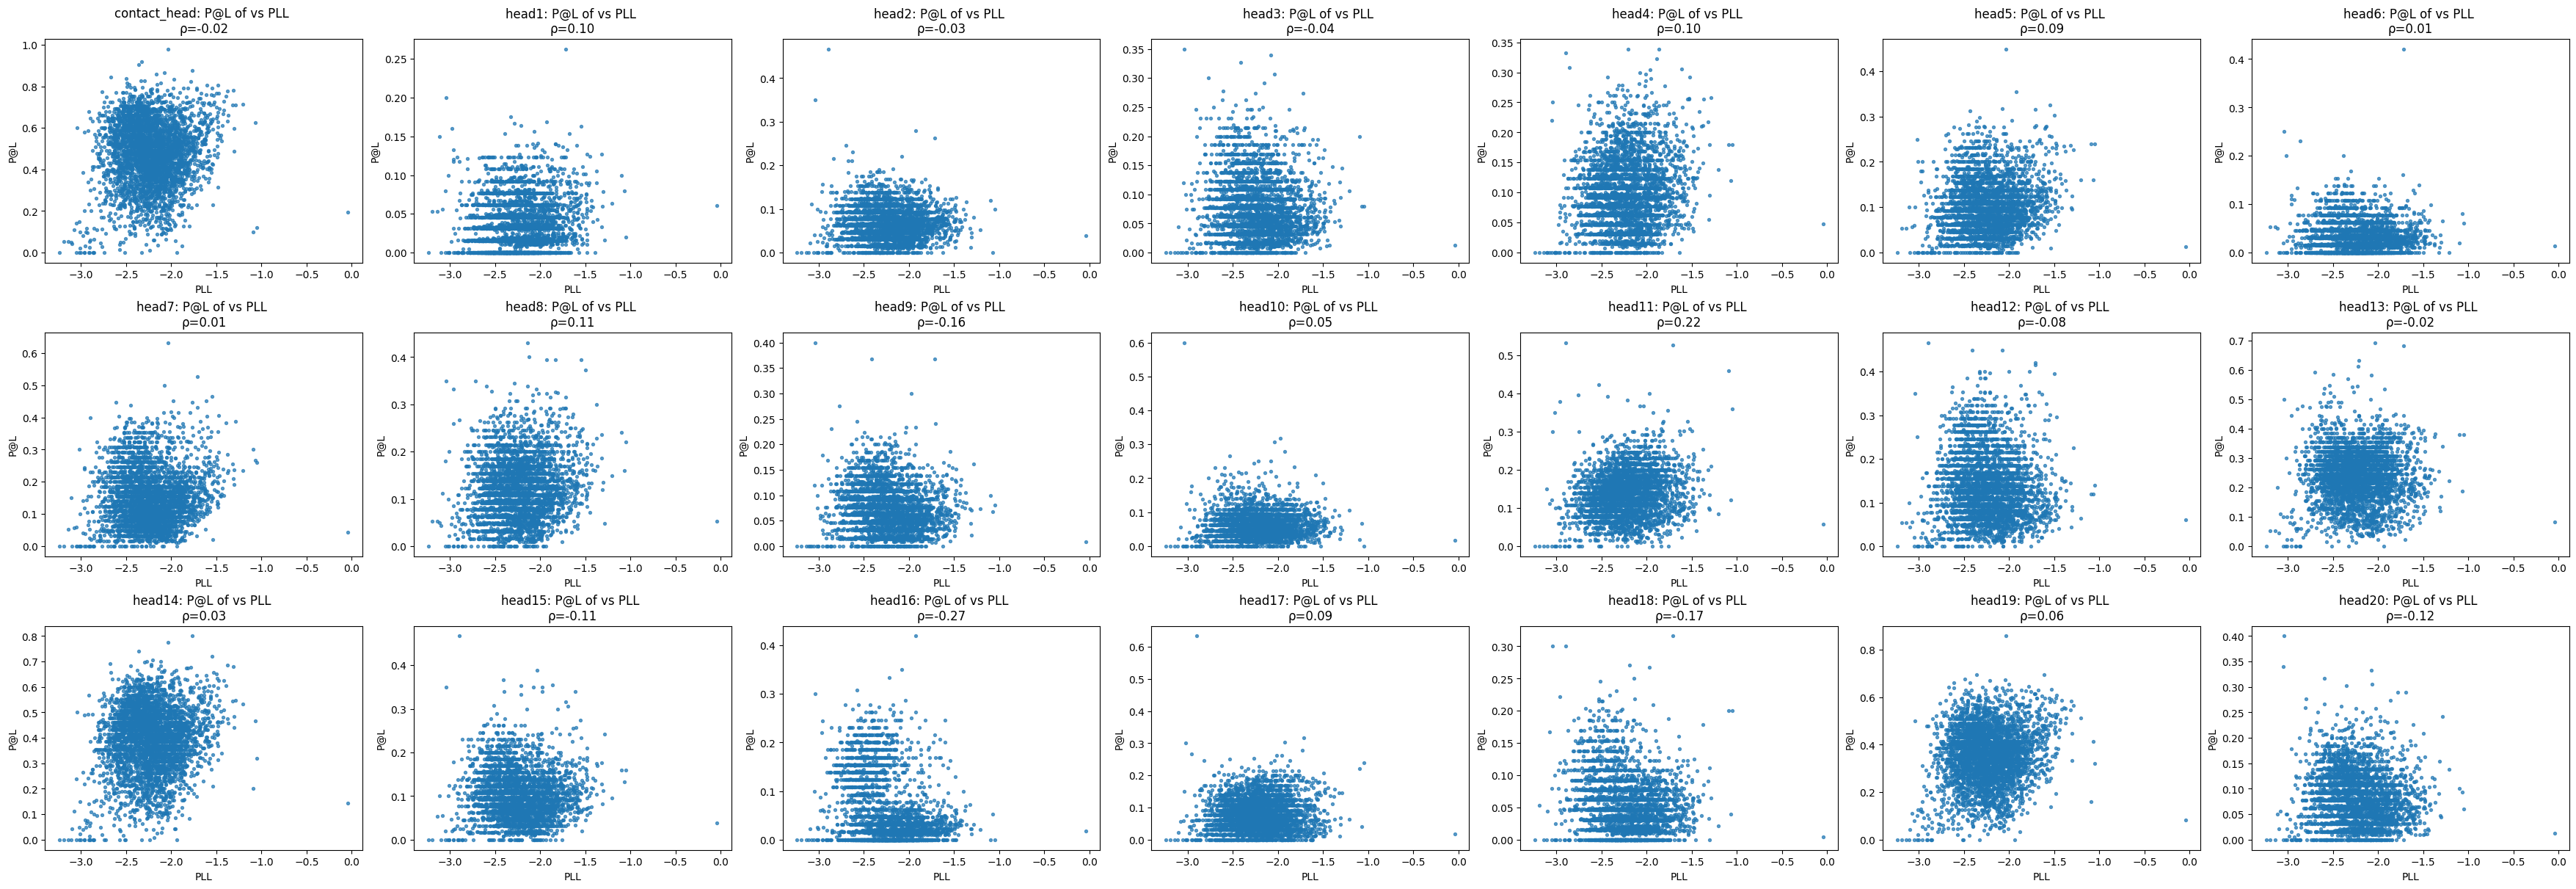

In [9]:
ycols = ["contact_head"] + [f"head{i}" for i in range(1, 21)]
nplots = len(ycols)
ncols = 7
nrows = ceil(nplots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = np.array(axes).reshape(nrows, ncols)

for ax, attn in zip(axes.ravel(), ycols):
    x, y = final_df["avg_log_likelihood"].to_numpy(), final_df[attn].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)

    # plotting
    ax.scatter(x, y, s=8, alpha=0.7)
    ax.set_title(f"{attn}: P@L of vs PLL \nρ={rho:.2f}")#, p={p:.1e}, n={len(x)}")
    ax.set_xlabel("PLL")
    ax.set_ylabel("P@L")

for ax in axes.ravel()[len(ycols):]:
    ax.axis("off")

plt.show()

/tmp/ipykernel_870834/263231616.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


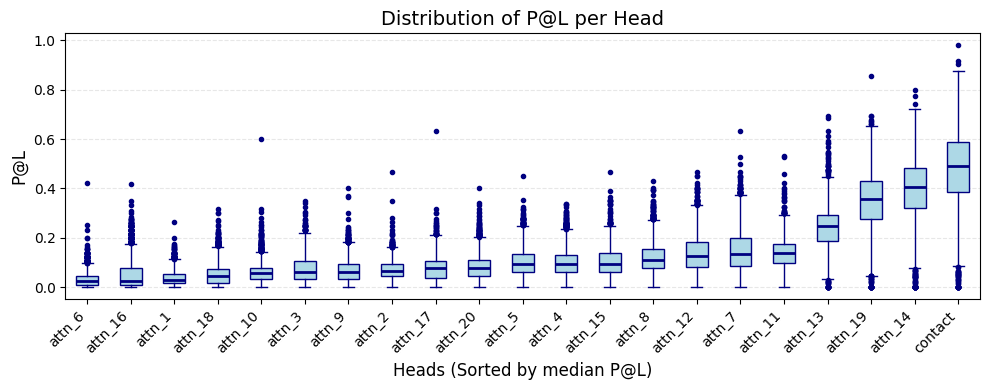

In [17]:
# 1. Identify the heads
head_cols = [col for col in final_df.columns if col.startswith("head") or col.startswith("contact_head")]

# 2. Calculate medians to determine the sort order
medians = final_df[head_cols].median().sort_values(ascending=True)
sorted_heads = medians.index.tolist()

# 3. Create a renaming mapping
# Assuming 'contact_head' is the unique one and 'head_X' are the others
rename_map = {}
for col in head_cols:
    if "contact" in col:
        rename_map[col] = "contact"
    else:
        # Extract the number from 'head_X'
        num = col.split('_')[-1][4:]
        rename_map[col] = f"attn_{num}"

# 4. Prepare data for plotting
# We use the sorted order here
plot_data = [final_df[h].dropna() for h in sorted_heads]
sorted_labels = [rename_map[h] for h in sorted_heads]

plt.figure(figsize=(10, 4))

# 5. Create the Boxplot
plt.boxplot(
    plot_data,
    labels=sorted_labels,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='navy'),
    capprops=dict(color='navy'),
    whiskerprops=dict(color='navy'),
    flierprops=dict(markerfacecolor='navy', markeredgecolor='navy', markersize=3),
    medianprops=dict(color='navy', linewidth=2)
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("P@L", fontsize=12)
plt.xlabel("Heads (Sorted by median P@L)", fontsize=12)
plt.title("Distribution of P@L per Head", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_870834/4195727141.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


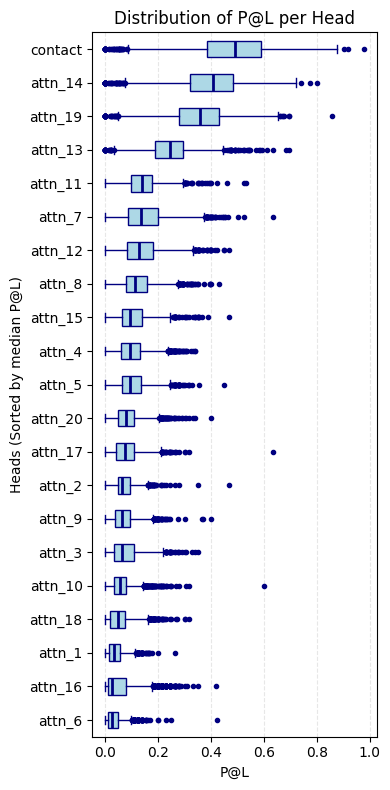

In [20]:
plt.figure(figsize=(4, 8)) # Swap the figsize: taller than it is wide

# 5. Create the Horizontal Boxplot
plt.boxplot(
    plot_data,
    labels=sorted_labels,
    vert=False,             # This is the key change!
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='navy'),
    capprops=dict(color='navy'),
    whiskerprops=dict(color='navy'),
    flierprops=dict(markerfacecolor='navy', markeredgecolor='navy', markersize=3),
    medianprops=dict(color='navy', linewidth=2)
)

# Swap the X and Y labels
plt.xlabel("P@L", fontsize=10)
plt.ylabel("Heads (Sorted by median P@L)", fontsize=10)
plt.title("Distribution of P@L per Head", fontsize=12)

# Adjust grid to show vertical lines instead of horizontal
plt.grid(axis='x', linestyle='--', alpha=0.3) 

# Note: You likely won't need rotation=45 anymore for Y-axis labels
plt.tight_layout()
plt.show()

### P@L vs avergae log-likelihood

In [ ]:
# xcol = "avg_log_likelihood"
# ycols = ["contact_head"] + [f"head{i}" for i in range(1, 21)]

# # cover NaNs
# work = final_df[[xcol] + ycols].replace([np.inf, -np.inf], np.nan)

# rows = []
# for y in ycols:
#     s = work[[xcol, y]].dropna()
#     rho, p = spearmanr(s[xcol], s[y])
#     rows.append({"metric": y, "n": len(s), "spearman_rho": rho})

# corr_df = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
# print(corr_df.to_string(index=False))
# print("")

import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from scipy.stats import spearmanr

# Assuming final_df exists and has the necessary columns

ycols = ["contact_head"] + [f"head{i}" for i in range(1, 21)]
ynames = ["contact_head"] + [f"attention_head_{i}" for i in range(1, 21)]
nplots = len(ycols)
ncols = 7
nrows = ceil(nplots / ncols)

# Increase figure size slightly to accommodate super labels and title
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)
axes = np.array(axes).reshape(nrows, ncols)

for ax, attn, name in zip(axes.ravel(), ycols, ynames):
    x, y = final_df["avg_log_likelihood"].to_numpy(), final_df[attn].to_numpy()

    # mask NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    if len(x) > 1:
        rho, p = spearmanr(x, y)
        rho_str = f"{rho:.2f}"
    else:
        rho_str = "N/A"

    # plotting
    ax.scatter(x, y, s=8, alpha=0.7)
    # Simplified individual titles
    ax.set_title(f"{name}\nρ={rho_str}")
    
    # REMOVED individual axis labels inside the loop to make room for the "big names"
    # ax.set_xlabel("Pseudo-log-likelihood")
    # ax.set_ylabel("P@L")

# Hide unused axes
for ax in axes.ravel()[len(ycols):]:
    ax.axis("off")

# --- Add Main Title and Big Axis Labels ---

# Add a main title to the entire figure
fig.suptitle("Correlation between Sequence Likelihood (PLL) and Structural Precision (P@L) across Heads", 
             fontsize=28, y=1.05)

# Add "big names" (super labels) to the common y and x axes
# fontsize='xx-large' makes them significantly bigger than standard tick labels
fig.supylabel("Precision at L (P@L)", fontsize=24, x=-0.015)
fig.supxlabel("Pseudo-Log-Likelihood (PLL)", fontsize=24, y=-0.05)

plt.show()

**Take away:** 
1) there’s no clear monotonic relationship between how probable the sequence looks to your language model (PLL) and how accurate your contact predictions are.
2) **sensitive model** - low PLL points have high P@L, while high PLL points have low P@L - precission of the model is highly depended on the encoding (PLL)
3) **robust model** - P@L is not that depended on the PLL - slightly inaccurate encodings will not affect model's performance that much.

### Length (L): longer sequences tend to have lower P@L (harder task) and different PLL ranges.

In [ ]:
patLs_PLLs_df

In [ ]:
# Sort by x so rolling works left→right
df = patLs_PLLs_df.sort_values("len_binder").copy()
focus = "head19"

# Compute running mean over y (choose window size to taste)
WINDOW = 10  # try 20/50/100 depending on your data size
df["running_mean"] = (df[focus].rolling(window=WINDOW, min_periods=1, center=True).mean())

# Plot
ax = sns.scatterplot(data=patLs_PLLs_df, x="len_binder", y=focus, alpha=0.7)
sns.lineplot(data=df, x="len_binder", y="running_mean", linewidth=2, color="red", ax=ax)
plt.show()